# Table of Contents


* **Getting Started**: importing/setting up the data
* **The Long Way** : manually doing all the typical steps of pre-processing/training/predicting, using **oo-learning** classes
    * Splitting
    * Transforming
    * Training
    * Predicting
    * Evaluating
* **The Short Way**: presents the **`ModelTrainer`** class, which encapsulates all of the previously mentioned steps.

Note: this notebook is meant to be a demo of some of the capabilities of **`oo-learning`** (https://github.com/shane-kercheval/oo-learning); it is not meant to show the best approach to exploring/cleaning/modeling this particular dataset. Also, with most graphs (e.g. correlations/box-plots/etc.) I will spend very little time commenting on the significance of any interesting or patterns. Again, the intent is to show a demo, not a guide to data analysis. 

# Getting Started

In the last Notebook, https://github.com/shane-kercheval/oo-learning/blob/master/examples/classification-titanic/1-Exploring%20the%20Titanic%20Dataset.ipynb, I showed how to get started and explore the dataset. In this Notebook, we'll look at basic operations like training models, transformations, etc.

## Set Up Environment

In [40]:
# !pip install oolearning --upgrade

In [41]:
from oolearning import *
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

## Import Data

`ExploreClassificationDataset` is a convenience class described in the [first notebook of this series](https://github.com/shane-kercheval/oo-learning/blob/master/examples/classification-titanic/1-Exploring%20the%20Titanic%20Dataset.ipynb).

In [42]:
csv_file = '../data/titanic.csv'
target_variable = 'Survived'
target_mapping = {0: 'died', 1: 'lived'}  # so we can convert from numeric to categoric

explore = ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                target_variable=target_variable,
                                                map_numeric_target=target_mapping)

In [43]:
explore.dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,died,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,lived,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,lived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,lived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,died,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# The Long Way

The following sections provide a demo of the basic individual classes that are used when training a model. 

In the **`"The Short Way"`** section, next, I demo some of the classes that encapsulate the logic and take care of the mundane and repetitive tasks.  

## Splitting the Data

Let's start out by splitting our data into a training set and holdout set.

To do this, we can use, for example, the **`ClassificationStratifiedDataSplitter`**, which as the name suggests, splits the data into training/holdout sets while maintaining the categorical proportions of the target variable. Technically, the Splitter will give us the indexes that should go into each set, and we will make the split.

In [44]:
splitter = ClassificationStratifiedDataSplitter(holdout_ratio=0.20)  # set aside 20% of the data for the holdout set

training_x,\
training_y,\
holdout_x, \
holdout_y = splitter.split_sets(data=explore.dataset, target_variable=target_variable)

In [45]:
training_x.shape

(712, 11)

In [46]:
holdout_x.shape

(179, 11)

Let's check to make sure the Splitter did the other part of its job, which was to split the data in a stratified way, keeping the proportions of the target variable the same.

In [47]:
training_y.value_counts(normalize=True)

died     0.616573
lived    0.383427
Name: Survived, dtype: float64

In [48]:
holdout_y.value_counts(normalize=True)

died     0.614525
lived    0.385475
Name: Survived, dtype: float64

Pretty close!

## Transforming the Data

Frequently, we need to transform the data before we can train it with various models.

Additionally, we'll want to *fit* transformations on the training set (i.e. the transformation object will extract the necessary attributes from the training set (e.g. median values for each column for a transformer that imputes missing values)) and then apply those same transformations to the holdout set (i.e. use the medians calculated/fitted on the training set, rather than the holdout set).

Let's create a list of transformation objects that we want to apply to the training and holdout sets.

In [49]:
transformations = [RemoveColumnsTransformer(['PassengerId', 'Name', 'Ticket', 'Cabin']),  # remove these columns
                   CategoricConverterTransformer(['Pclass', 'SibSp', 'Parch']),  # convert these columns to categoric
                   ImputationTransformer(group_by_column='Pclass',
                                         treat_zeros_as_na=True),  # impute all missing values (default is median for numeric, and most frequent class for categoric)
                   DummyEncodeTransformer(CategoricalEncoding.DUMMY)]  # create dummy variables for categoric features

Note that the **`ImputationTransformer`** can take (among other parameters) optional parameters called **`treat_zeros_as_na`** and **`group_by_column`**.

**`treat_zeros_as_na`** treats values of `0` (for numeric features) as `NA`, meaning that it will impute/overwrite these values, even though they aren't missing. Why would we do this? Well in `1-Exploring the Titanic Dataset`, we saw that the titanic datset has `15` people associated with a `Fare` of `$0`, which we might think of as being a mistake or the same as missing data.

**`group_by_column`** allows us to fit/impute (e.g. take the median of) the values within the context of a different column, i.e. the `group_by_column`. So, for example, when imputing the `Fare` feature, rather than just filling missing values with the median of all the `Fare`s, we can take the median of the `Fare` for each unique group of `Pclass` column. So first we calculate the median for each group by `Pclass` (`Lower`, `Middle`, `Upper`), and then, for example, if we are imputing the value of a `Fare` associated with someone who we know is associated with the `Upper` class, then we give that person the median value of that group.

In order to help manage all of the transformations we want to do, we'll use the **`TransformerPipeline`** class and fit/transform the training data, then transform (without fitting) the holdout data.

In [50]:
pipeline = TransformerPipeline(transformations=transformations)
transformed_training_data = pipeline.fit_transform(training_x)  # fit & transform
transformed_holdout_data = pipeline.transform(holdout_x)  # fit only

In [51]:
training_x.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
692,693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S
855,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S


In [52]:
transformed_training_data.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
692,24.0,56.4958,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
481,29.0,15.0479,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
527,38.0,221.7792,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
855,18.0,9.3500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
801,31.0,26.2500,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1



Notice that for passenger `482` (row `481`), Mr. Frost had a Fare of `$0`. Because we treated `0` as `NA`, this value was updated to `$15.0479`, which is the `median` value for tickets associated with a `Pclass` of `2`, as shown below.

In [53]:
import numpy as np
training_x.replace(0, np.nan).groupby('Pclass')['Fare'].median()

Pclass
1    61.6792
2    15.0479
3    8.0500 
Name: Fare, dtype: float64

Also note that we might not want to treat zeros as NA values for all features, or might not want to group by the same feature for all of the features we impute. In these cases, `ImputationTransformer` also includes parameters for including (only) an excluding features, **`columns_explicit`** and **`columns_to_ignore`**. So we can build multiple instances of `ImputationTransformer` to feed into our pipeline.

## Training a Model, & Predicting

Finally, let's train a logistic regression model.

The pattern for training a model includes two classes in most cases. One class specifies the model, in this case **`LogisticClassifier`**, and the other class species the hyper-parameters we want to use in the model. The corresponding class for the Logistic model is **`LogisticClassifierHP`**.

The corresponding **`HP`** classes define the specific parameters that can be tuned, specified in the **`__init__(...)`** function. Instantiating the class without providing any values will result in default values being used.

In most cases, the model classes, such as `LogisticClassifier`, are wrappers around `scikit-learn` classes, and the `HP` classes' default values for the hyper-parameters are the same values that the underlying `scikit-learn` classes use.

In [54]:
model = LogisticClassifier()
model.train(data_x=transformed_training_data, data_y=training_y, hyper_params=LogisticClassifierHP())  # default hyper-parameters

In [55]:
print(model)

LogisticClassifier

Hyper-Parameters

{'C': 1.0
 'class_weight': None
 'dual': False
 'fit_intercept': True
 'intercept_scaling': 1
 'max_iter': 100
 'multi_class': 'ovr'
 'n_jobs': 1
 'penalty': 'l2'
 'random_state': 42
 'solver': 'liblinear'
 'tol': 0.0001
 'verbose': 0
 'warm_start': False}

Features Trained

['Age'
 'Fare'
 'Pclass_2'
 'Pclass_3'
 'Sex_male'
 'SibSp_1'
 'SibSp_2'
 'SibSp_3'
 'SibSp_4'
 'SibSp_5'
 'SibSp_8'
 'Parch_1'
 'Parch_2'
 'Parch_3'
 'Parch_4'
 'Parch_5'
 'Parch_6'
 'Embarked_Q'
 'Embarked_S']


In [56]:
predictions = model.predict(data_x=transformed_holdout_data)
predictions.head()

,died,lived
565,0.884223,0.115777
160,0.923645,0.076355
553,0.866481,0.133519
860,0.925227,0.074773
241,0.272832,0.727168


## Evaluating Performance

We've trained our model on the training data, and predicted on the holdout. Now we need some way of evaluating performance.

We could use, for example, `scikit-learn`'s confusion matrix, or kappa score via `cohen_kappa_score`, but first we have to translate the "probabilities" we have in the DataFrame, to an array or list of outcomes (e.g. "lived" / "died")

We can simply choose the class associated with the highest value.

In [57]:
predicted_classes = predictions.idxmax(axis=1).values 
pd.value_counts(predicted_classes)

died     120
lived    59 
dtype: int64

In [58]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix

confusion_matrix(y_true=holdout_y, y_pred=predicted_classes)

array([[98, 12],
       [22, 47]])

In [59]:
cohen_kappa_score(y1=holdout_y, y2=predicted_classes)

0.5879485443466486

### **`Evaluator`** object

Great, besides not knowing which rows/columns correspond to what in the confusion matrix, we are on our way to understanding the performance.

But there is an easier way.

We can use, for example, `oo-learning`'s **`TwoClassProbabilityEvaluator`** class, which also takes a `converter` class. A converter is simple a class that defines how we want to convert the DataFrame of probabilities (or continuous values) to a series of classes.

We can use a **`HighestValueConverter`** which does exactly the same thing that we previously did with `predictions.idxmax(axis=1).values`. The advantage to specifying it as an object means that we can pass in different objects, which encapsulate different methods for choosing the predicted class. For example, we might want to set a specific threshold of the positive class based an an ROC curve instead, in which case we would use a **`TwoClassThresholdConverter`** object.

Or we can use this object with it's default treshold of `0.5`, which is also equivalent to what we previously did.

In [60]:
evaluator = TwoClassProbabilityEvaluator(converter=TwoClassThresholdConverter(positive_class='lived',
                                                                              threshold=0.5))
evaluator.evaluate(actual_values=holdout_y, predicted_values=predictions)  # note, we gave it the raw DataFrame, not the converted classes

In [61]:
print(evaluator)

{'AUC ROC': 0.84466403
 'AUC Precision/Recall': 0.79229144
 'Kappa': 0.58794854
 'F1 Score': 0.734375
 'Two-Class Accuracy': 0.81005587
 'Error Rate': 0.18994413
 'True Positive Rate': 0.68115942
 'True Negative Rate': 0.89090909
 'False Positive Rate': 0.10909091
 'False Negative Rate': 0.31884058
 'Positive Predictive Value': 0.79661017
 'Negative Predictive Value': 0.81666667
 'Prevalence': 0.38547486
 'No Information Rate': 0.61452514
 'Total Observations': 179}

Confusion Matrix
----------------

predicted  died  lived  Total
actual                       
died       98    12     110  
lived      22    47     69   
Total      120   59     179  


In [62]:
evaluator.all_quality_metrics

{'AUC ROC': 0.8446640316205533,
 'AUC Precision/Recall': 0.7922914385299735,
 'Kappa': 0.5879485443466486,
 'F1 Score': 0.7343750000000001,
 'Two-Class Accuracy': 0.8100558659217877,
 'Error Rate': 0.18994413407821228,
 'True Positive Rate': 0.6811594202898551,
 'True Negative Rate': 0.8909090909090909,
 'False Positive Rate': 0.10909090909090909,
 'False Negative Rate': 0.3188405797101449,
 'Positive Predictive Value': 0.7966101694915254,
 'Negative Predictive Value': 0.8166666666666667,
 'Prevalence': 0.3854748603351955,
 'No Information Rate': 0.6145251396648045,
 'Total Observations': 179}

In [63]:
evaluator.matrix

predicted,died,lived,Total
actual,,,
died,98,12,110
lived,22,47,69
Total,120,59,179


# The Short Way


What we did is pretty standard, and we'll probably do the same set of generic steps time and time again.

**`ModelTrainer`** is a class the encapsulate the boring details of what we did, so we can do it a lot quicker and with more concise and descriptive code.

The following code has the identical result as all the work we did above.

In [64]:
# define how we want to split the training/holding datasets
splitter = ClassificationStratifiedDataSplitter(holdout_ratio=0.2)

# define the transformations
transformations = [RemoveColumnsTransformer(['PassengerId', 'Name', 'Ticket', 'Cabin']),
                   CategoricConverterTransformer(['Pclass', 'SibSp', 'Parch']),
                   ImputationTransformer(),
                   DummyEncodeTransformer(CategoricalEncoding.DUMMY)]

# Define how we want to evaluate (and convert the probabilities DataFrame to predicted classes)
evaluator = TwoClassProbabilityEvaluator(converter=
                                         TwoClassThresholdConverter(threshold=0.5,
                                                                    positive_class='lived'))

# give the objects, which encapsulate the behavior of everything involved with training the model, to our ModelTrainer
trainer = ModelTrainer(model=LogisticClassifier(),
                       model_transformations=transformations,
                       splitter=splitter,
                       evaluator=evaluator)
trainer.train_predict_eval(data=explore.dataset, target_variable='Survived', hyper_params=LogisticClassifierHP())

# access the holdout metrics (we also have `training_evaluator` available to us as well!) and get a summary
trainer.holdout_evaluator.all_quality_metrics

{'AUC ROC': 0.8458498023715415,
 'AUC Precision/Recall': 0.7926428620672208,
 'Kappa': 0.5879485443466486,
 'F1 Score': 0.7343750000000001,
 'Two-Class Accuracy': 0.8100558659217877,
 'Error Rate': 0.18994413407821228,
 'True Positive Rate': 0.6811594202898551,
 'True Negative Rate': 0.8909090909090909,
 'False Positive Rate': 0.10909090909090909,
 'False Negative Rate': 0.3188405797101449,
 'Positive Predictive Value': 0.7966101694915254,
 'Negative Predictive Value': 0.8166666666666667,
 'Prevalence': 0.3854748603351955,
 'No Information Rate': 0.6145251396648045,
 'Total Observations': 179}

In [65]:
print(trainer.holdout_evaluator)

{'AUC ROC': 0.8458498
 'AUC Precision/Recall': 0.79264286
 'Kappa': 0.58794854
 'F1 Score': 0.734375
 'Two-Class Accuracy': 0.81005587
 'Error Rate': 0.18994413
 'True Positive Rate': 0.68115942
 'True Negative Rate': 0.89090909
 'False Positive Rate': 0.10909091
 'False Negative Rate': 0.31884058
 'Positive Predictive Value': 0.79661017
 'Negative Predictive Value': 0.81666667
 'Prevalence': 0.38547486
 'No Information Rate': 0.61452514
 'Total Observations': 179}

Confusion Matrix
----------------

predicted  died  lived  Total
actual                       
died       98    12     110  
lived      22    47     69   
Total      120   59     179  


In [66]:
print(trainer)

LogisticClassifier

Hyper-Parameters

{'C': 1.0
 'class_weight': None
 'dual': False
 'fit_intercept': True
 'intercept_scaling': 1
 'max_iter': 100
 'multi_class': 'ovr'
 'n_jobs': 1
 'penalty': 'l2'
 'random_state': 42
 'solver': 'liblinear'
 'tol': 0.0001
 'verbose': 0
 'warm_start': False}

Features Trained

['Age'
 'Fare'
 'Pclass_2'
 'Pclass_3'
 'Sex_male'
 'SibSp_1'
 'SibSp_2'
 'SibSp_3'
 'SibSp_4'
 'SibSp_5'
 'SibSp_8'
 'Parch_1'
 'Parch_2'
 'Parch_3'
 'Parch_4'
 'Parch_5'
 'Parch_6'
 'Embarked_Q'
 'Embarked_S']

Training Evaluator

{'AUC ROC': 0.86038032
 'AUC Precision/Recall': 0.83891703
 'Kappa': 0.58078692
 'F1 Score': 0.73151751
 'Two-Class Accuracy': 0.80617978
 'Error Rate': 0.19382022
 'True Positive Rate': 0.68864469
 'True Negative Rate': 0.87927107
 'False Positive Rate': 0.12072893
 'False Negative Rate': 0.31135531
 'Positive Predictive Value': 0.78008299
 'Negative Predictive Value': 0.81953291
 'Prevalence': 0.38342697
 'No Information Rate': 0.61657303
 'Total 

In [67]:
trainer.holdout_evaluator.matrix

predicted,died,lived,Total
actual,,,
died,98,12,110
lived,22,47,69
Total,120,59,179


In [68]:
trainer.holdout_evaluator.confusion_matrix.matrix_proportions

predicted,died,lived,Total
actual,,,
died,0.547486,0.067039,0.614525
lived,0.122905,0.262570,0.385475
Total,0.670391,0.329609,1.000000


In [79]:
trainer.holdout_evaluator.confusion_matrix.plot(include_totals=True,
                                                proportions=True)

TypeError: plot() got an unexpected keyword argument 'proportions'

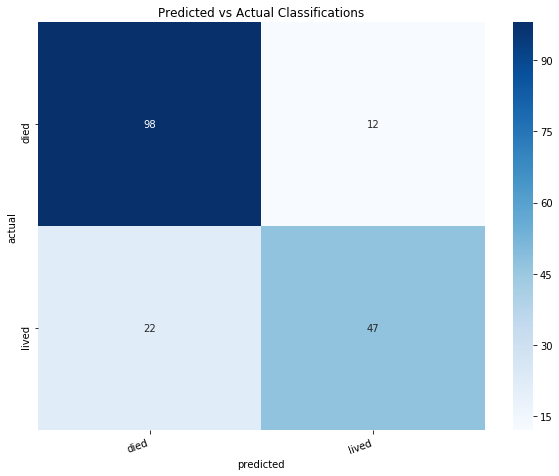

In [91]:
trainer.holdout_evaluator.confusion_matrix.plot()

We can also plot all of the previous metrics

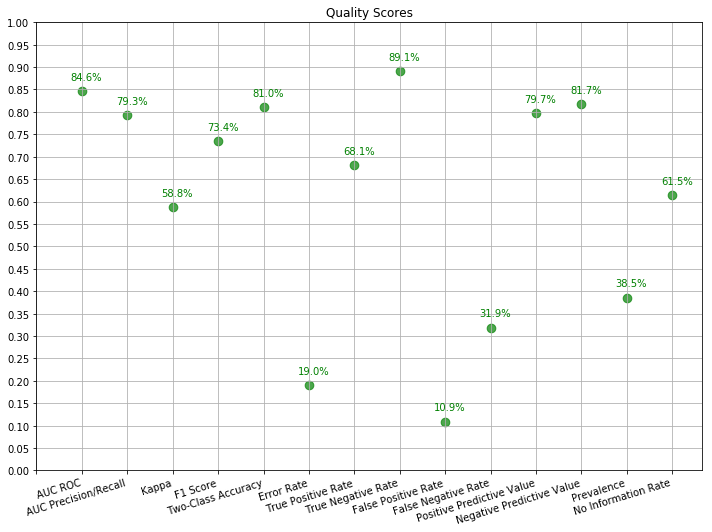

In [80]:
trainer.holdout_evaluator.plot_all_quality_metrics()

Or, we can plot the previous metrics with with another evaluator object and compare the values. Below, we can pass in the training evaluator in order to compare the training metrics (reg) vs the holdout metrics (green).

For example, the `training AUC` is `0.86` while the `holdout AUC` is `0.845`

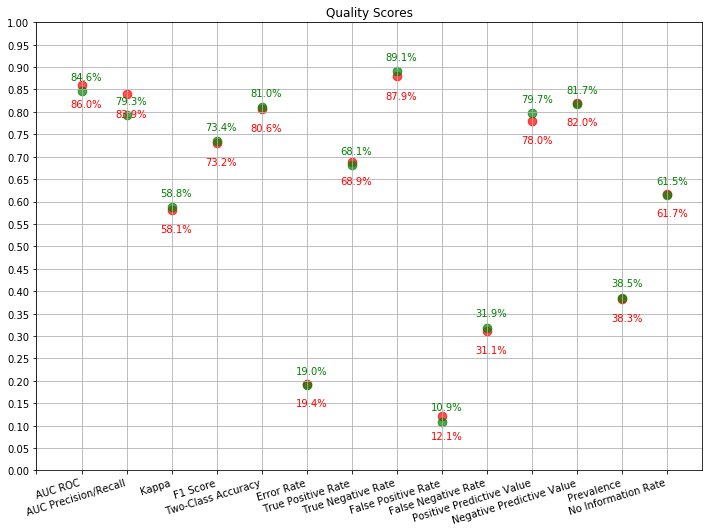

In [81]:
trainer.holdout_evaluator.plot_all_quality_metrics(comparison_evaluator=trainer.training_evaluator)

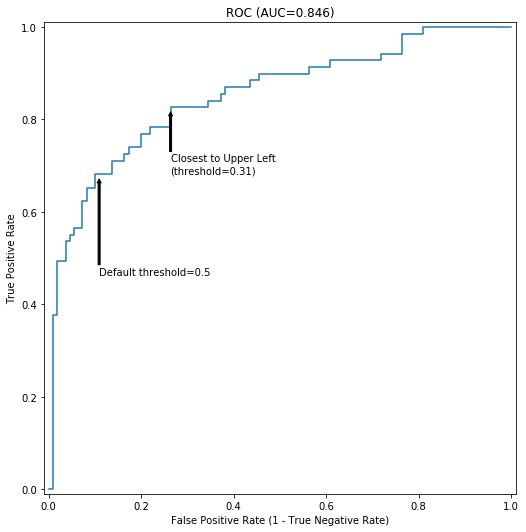

In [82]:
trainer.holdout_evaluator.plot_roc_curve()

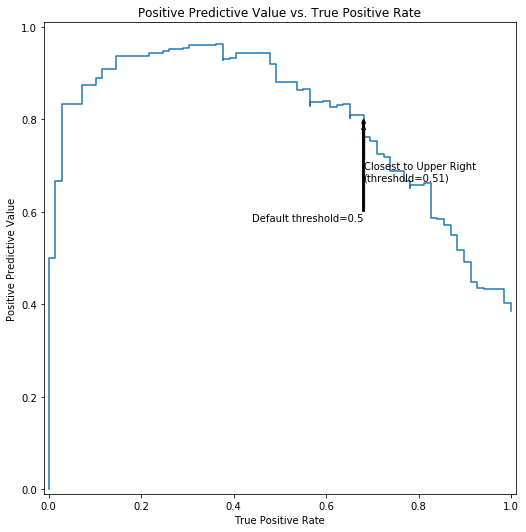

In [83]:
trainer.holdout_evaluator.plot_ppv_tpr_curve()

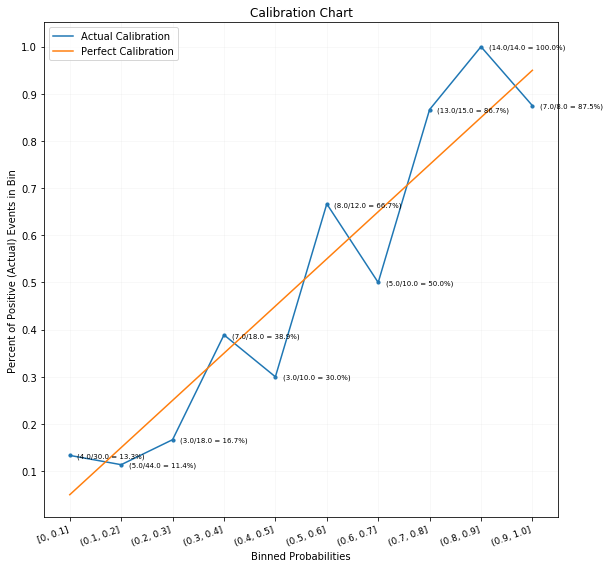

In [84]:
trainer.holdout_evaluator.plot_calibration()

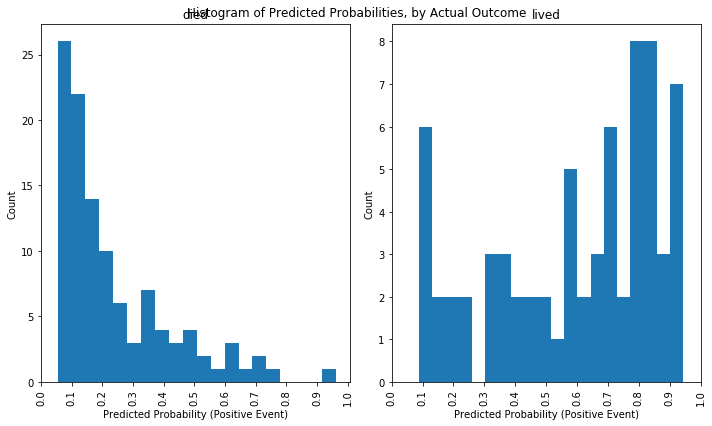

In [85]:
trainer.holdout_evaluator.plot_predicted_probability_hist()

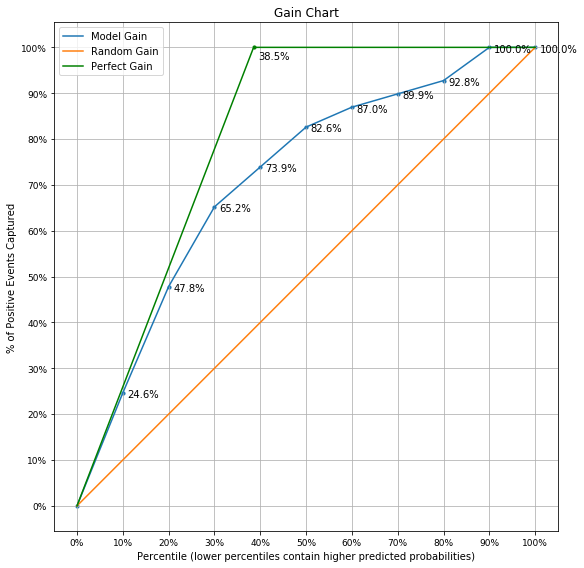

In [86]:
trainer.holdout_evaluator.plot_gain_chart()

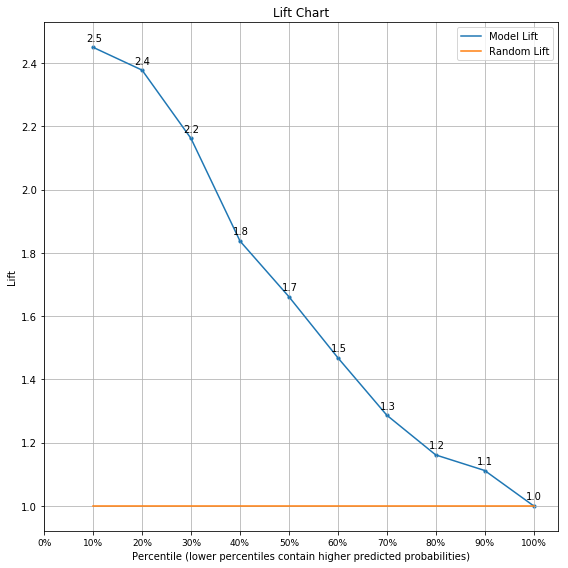

In [87]:
trainer.holdout_evaluator.plot_lift_chart()